[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ciri/iese-dsfb/blob/main/notebooks/210-Amazon-Part-I.ipynb)

# Tabular: Amazon Part I

## Data Familiarization

You're working with real Amazon India Female fashion sales data from their Q2 2022 MRP which you can download [here](https://raw.githubusercontent.com/ciri/iese-dsfb/main/resources/tabular/AmazonSalesReport.csv). This dataset provides detailed insights into Amazon sales data, including SKU, product design, category, size, pricing, and fulfillment details. It is useful for analyzing sales performance and optimizing product profitability. Before doing any analysis, you need to understand what data you're looking at:

* What does each row represent?
* What kind of columns are available?
* Are there missing values?

First step: always **look at your data**. Use `.head()` to see a sample, `.info()` to understand the structure, and `.describe()` for numeric summaries. We'll answer those questions using a few simple commands in pandas.

Some datasets also come with a `data card`, here's the one for this dataset:


| **Variable**       | **Description**                                               | **Type**    |
|--------------------|---------------------------------------------------------------|-------------|
| `category`         | Type of product (e.g., kurta, set, top)                       | String      |
| `size`             | Size of the product                                           | String      |
| `date`             | Date of the sale                                              | Date        |
| `status`           | Status of the order (e.g., Shipped, Cancelled)                | String      |
| `fulfilment`       | Who fulfilled the order (Amazon or Merchant)                  | String      |
| `style`            | Style identifier of the product                               | String      |
| `sku`              | Stock Keeping Unit, unique product ID                         | String      |
| `asin`             | Amazon Standard Identification Number                         | String      |
| `courier_status`   | Current status of the shipping courier                        | String      |
| `qty`              | Quantity of items ordered                                     | Integer     |
| `amount`           | Sale amount (in INR)                                          | Float       |
| `b2b`              | Whether the customer is a business                            | Boolean     |
| `currency`         | Currency used for the transaction (usually INR)               | String      |


In [83]:
import pandas as pd

df = pd.read_csv('../resources/tabular/AmazonSalesReport.csv')

C:\Users\enric\AppData\Local\Temp\ipykernel_7036\2992268346.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../resources/tabular/AmazonSalesReport.csv')


You may be getting a warning. When pandas loads a CSV, it tries to infer the data type of each column (int, float, object, etc.). If a column has both numbers and text, pandas gets confused. Column 23 (24th column, likely 'fulfilled-by') has mixed types - probably some strings like "Easy Ship" and some missing values (NaN) or unexpected values like False.

In [84]:
df.head(3)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22,base-SKU
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN,SET389
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN,JNE3781
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN,JNE3371


In [85]:
df.describe()

,index,Qty,Amount,ship-postal-code
count,126514.000000,126514.000000,118728.000000,126481.000000
mean,64474.154813,0.902691,661.099273,464452.737217
std,37243.711860,0.315949,268.982377,191271.827748
min,0.000000,0.000000,0.000000,110001.000000
25%,32171.250000,1.000000,458.000000,382455.000000
50%,64508.500000,1.000000,621.450000,500034.000000
75%,96728.750000,1.000000,788.000000,600028.000000
max,128974.000000,15.000000,5584.000000,989898.000000


### 🧹 Data Cleaning

Before we can trust or analyze this data, we need to clean it. That means:

* Standardize column names so they’re consistent
* Drop unnecessary columns (like Excel export leftovers)
* Handle missing values in a simple, safe way

**Drop irrelevant columns**

In [86]:
df.columns # at the end there's a weird one, likely someone added one comma too many or had a value in excel at the end of the row
           # we also don't need this index

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22', 'base-SKU'],
      dtype='object')

In [87]:
df = df.drop(columns=['Unnamed: 22', 'index'])

**Rename columns**

Let's clean up some column names, ideally in python no spaces. Let's make it all very consistent.

In [88]:
# Rename confusing column names for clarity
df = df.rename(columns={
    'Order ID': 'order_id',
    'Date': 'date',
    'Status': 'status',
    'Fulfilment': 'fulfilment',
    'Sales Channel ': 'sales_channel',
    'ship-service-level': 'ship_service_level',
    'Style': 'style',
    'Category': 'category',
    'Size': 'size',
    'Courier Status': 'courier_status',
    'Qty': 'qty',
    'currency': 'currency',
    'Amount': 'amount',
    'ship-city': 'ship_city',
    'ship-state': 'ship_state',
    'ship-postal-code': 'ship_postal_code',
    'ship-country': 'ship_country',
    'promotion-ids': 'promotion_ids',
    'fulfilled-by': 'fulfilled_by',
})
df.head(3)

,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,SKU,category,size,...,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,B2B,fulfilled_by,base-SKU
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,SET389
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,JNE3781
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,JNE3371


**Handle missing values**

Are there missing values?

In [89]:
df.isna().sum()

order_id                  0
date                      0
status                    0
fulfilment                0
sales_channel             0
ship_service_level        0
style                     0
SKU                       0
category                  0
size                      0
ASIN                      0
courier_status         6866
qty                       0
currency               7786
amount                 7786
ship_city                33
ship_state               33
ship_postal_code         33
ship_country             33
promotion_ids         47530
B2B                       0
fulfilled_by          88023
base-SKU                  0
dtype: int64

Note that `df.isna()` is a data frame of the same shape as `df`, whose terms have type `bool`. With `sum`, we get the number of `True` values per column.

Missing values are denoted by `NaN` in Pandas. When a Pandas object is built, both plain Python’s `None` and NumPy’s `nan` are taken as NaN. Since `np.nan` has type `float`, a numeric series containing NaN values
gets type float.

Three useful Pandas methods related to missing values, which can be applied to both series and data frames, are:
* `isna` returns a Boolean mask indicating which terms are missing.
* `fillna` is used for replacing `NaN`’s by a fixed value, set by the user.
* `dropna` returns the same data frame minus the rows that contain at least one missing value. If a list of columns is specified, the missing values are searched only for those columns.

For our case, let’s apply the following business rules:

- If *amount* or *currency* is missing, drop the row (we can't use it for financial analysis).
- If *courier status* is missing, fill it with `"Unknown"`.

The rest we leave as is.

In [90]:
df = df.dropna(subset=['amount', 'currency']).copy()
df['courier_status'] = df['courier_status'].fillna('Unknown')

**Remove Duplicates**

There are two useful Pandas functions for managing duplicates:

* `drop_duplicates` drops the duplicated entries (in a series) or the duplicated rows (in a data frame).
* `duplicated` returns a Boolean series indicating which entries (for a series) or which rows (for a data
frame) are duplicated.

In [91]:
df.duplicated().sum()

np.int64(3)

In [92]:
print('Before dropping duplicates:', df.shape)
df = df.drop_duplicates()
print('After dropping duplicates:', df.shape)

Before dropping duplicates: (118728, 23)
After dropping duplicates: (118725, 23)


**Any other final conversion**

Since I am not too familiar (intuitively) with INR, I prefer to convert to Euro.

In [93]:
exchange_rate = 0.0118 # In 2022
df['amount_eu'] = (df['amount'] * exchange_rate).round(2)

It's good practice to save the dataframe after preprocessing this allows you to continue with a clean dataset going forward.

In [94]:
df.to_csv('../resources/tabular/Amazon-cleaned.csv', index=False)

## Exploratory Analysis

In [95]:
df = pd.read_csv('../resources/tabular/Amazon-cleaned.csv')
df.head(3)

,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,SKU,category,size,...,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,B2B,fulfilled_by,base-SKU,amount_eu
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,SET389,7.64
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,JNE3781,4.79
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,JNE3371,3.88


### Revenue Trend over Time

### Revenue

**You try it**

Create a new variable / column for revenue. Anything weird going on? 

Hint: use the `describe()` function or look at the min/max.

### Adding time

Pandas has powerful tools to help you work with dates - but dates start as plain text ("strings"), which can't be analyzed or sorted properly.

So first, we **convert the `date` column** into a proper **datetime object**. Once we do that, we unlock a *lot* of cool tricks. Here's the flow:


| Concept              | What it Does                                                              |
|----------------------|---------------------------------------------------------------------------|
| `pd.to_datetime()`   | Converts text into a proper date format                                   |
| `.dt`                | A special "datetime accessor" in pandas - lets you pull out month, day, etc. |
| `.dt.month_name()` | Extracts the **month name** (e.g., "April") from a full date              |

In [96]:
df['date'] = pd.to_datetime(df['date'])

C:\Users\enric\AppData\Local\Temp\ipykernel_7036\3532345252.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [97]:
df['month'] = df.date.dt.month_name()

To report sales per month we need to do a groupby.

Suppose that you are interested in the average price per room type. You can get this by applying `groupby()` which works as follows:

<center>
<img src='../images/pandas_groupby.png' width='100%'>
</center>


This method groups the rows according to one or more **grouping variables**. Here, you specify `groupby(by='room_type')`. 

Next, you select the columns to be aggregated, which, here would be just `price`. Finally, you specify the **aggregation function**. Having only the mean, you can do it just by adding `mean()` or by specifying `.agg('mean')`. The method `round()` works as you would expect it to.

In [98]:
monthly_revenue = df.groupby('month')[['revenue']].sum()
monthly_revenue

KeyError: "Columns not found: 'revenue'"

In [ ]:
# Let's order the months correctly and plot
# We will also drop March as its clearly incomplete
month_order = ['April', 'May', 'June']
monthly_revenue = monthly_revenue.loc[month_order]
monthly_revenue

,revenue
month,
April,328611.70
May,298847.94
June,268579.04


In [ ]:
# Calculate average revenue over last 3 months
# and how much below/above average we are
avg_q2_revenue = monthly_revenue['revenue'].mean()
avg_q2_revenue

monthly_revenue['% below avg'] = round((1 - monthly_revenue['revenue'] / avg_q2_revenue) * 100, 1)
monthly_revenue

,revenue,% below avg
month,,
April,328611.70,-10.0
May,298847.94,-0.1
June,268579.04,10.1


In [ ]:
monthly_revenue

,revenue,% below avg
month,,
April,328611.70,-10.0
May,298847.94,-0.1
June,268579.04,10.1


Charts are often more persuasive than tables. We will not waste time teaching this as you can ask LLM's to provide this to you. You can "vibe"-chart your way to great visualizations, just make sure that your dataframe above is 100% correct!

C:\Users\enric\AppData\Local\Temp\ipykernel_7036\491843133.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(range(0, 41, 5)))


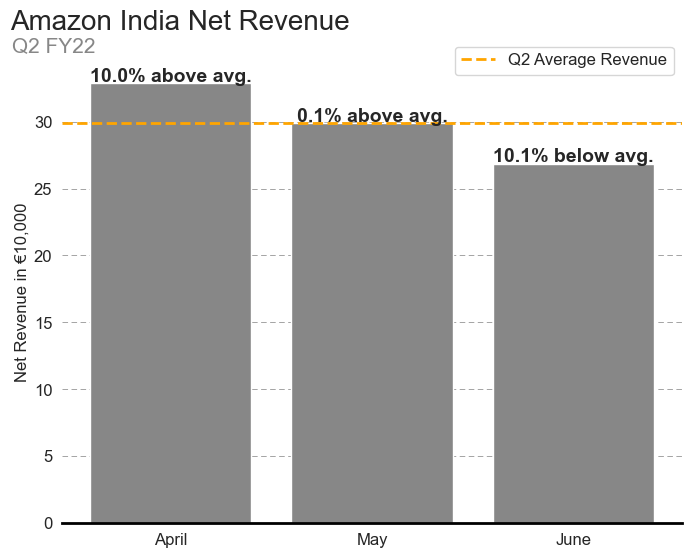

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars
bars = ax.bar(monthly_revenue.index, monthly_revenue['revenue'], color='#878787')

# Add horizontal line for average
ax.axhline(avg_q2_revenue, linestyle='--', color='orange', linewidth=2, label='Q2 Average Revenue')

# Annotate each bar
for bar, pct in zip(bars, monthly_revenue['% below avg']):
    ax.annotate(f"{pct}% below avg." if pct > 0 else f"{abs(pct)}% above avg.",
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height() - 7000),
                xytext=(0, 8), textcoords='offset points',
                ha='center', fontsize=14, fontweight='bold')

# Titles and labels
ax.set_title("Amazon India Net Revenue", fontsize=20, x=0.19, y=1.05)
ax.text(-0.08, 1.02, "Q2 FY22", fontsize=15, color='#878787', transform=ax.transAxes)
ax.set_ylabel('Net Revenue in €10,000', fontsize=12, labelpad=3)
ax.set_xlabel(None)

# Ticks and grid
ax.set_yticklabels(list(range(0, 41, 5)))
ax.yaxis.grid(linestyle='--', color='gray', linewidth=0.5, dashes=(8, 5))
ax.xaxis.grid(False)
ax.tick_params(axis='both', labelsize=12)

# Spines
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')

plt.legend(bbox_to_anchor=(1,1.05), fontsize=12, fancybox=True)
plt.show()

> Analysis: Revenue went down in June, this might be seasonal  or a campaign issue. One month is much higher, need to check if what the reason is (promotion?). Revenue is flat ...market saturation or consistent demand?


**You try it**

On which days is Amazon earning most of its revenue in India?

1. First create a column containing the day of the week. Hint: use `dt.day_name()` for this (day of the week) or alternatively `dt.day` (day of month).
2. Then, use a groupby and an aggregation function to obtain the total revenue.
3. BONUS: plot the result using `df.plot.bar()` or `df.plot()`

## Product Portfolio Analysis

### Analysis: revenue across product categories?

Next question: **Which product categories generate the most revenue?**

Typical question to ask:
* Which category dominates revenue? Do we risk of over-dependence?
* Is there a drop-off after top 3 categories or any other long tail effect?
* Are high-volume categories also high-value? Might lead into later analysis (avg. order value).

We’ll use `groupby()` again, but this time by `category`. It works just like with months, but this helps us understand which types of products are performing best.


In [104]:
category_revenue = df.groupby('category')[['revenue']].sum()
category_revenue = category_revenue / category_revenue.sum() * 100

category_revenue = category_revenue.sort_values(ascending=False, by='revenue')
category_revenue

,revenue
category,
Set,49.882695
kurta,27.185384
Western Dress,14.094520
Top,6.898323
Ethnic Dress,1.003319
Blouse,0.580821
Bottom,0.188110
Saree,0.165622
Dupatta,0.001205


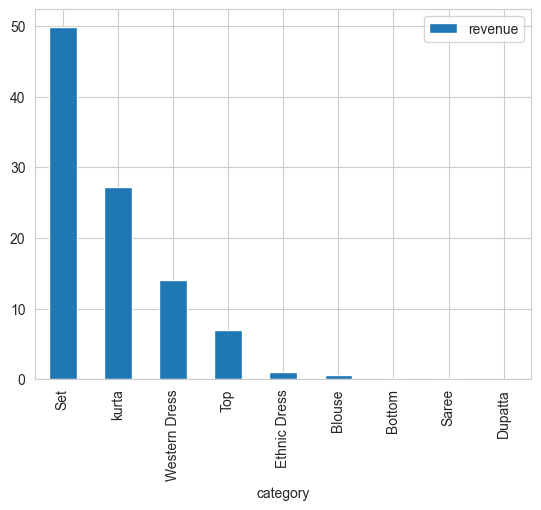

In [105]:
# Basic plot command
category_revenue.plot.bar();

### Analysis: Average Order Value by Category

Revenue alone doesn’t tell the full story. Some categories might generate fewer sales but have *higher order values*.

Let’s calculate **average revenue per order** (AOV) for each product category.

This helps answer: *Which categories sell for more money per order?*


In [106]:
avg_order_value = df.groupby('category')[['revenue']].mean()
avg_order_value = avg_order_value.sort_values(by='revenue', ascending=False)
avg_order_value

,revenue
category,
Set,9.720927
Saree,9.636623
Western Dress,8.723655
Ethnic Dress,8.481255
Top,6.188590
Blouse,6.065711
kurta,5.319058
Bottom,4.121125
Dupatta,3.600000


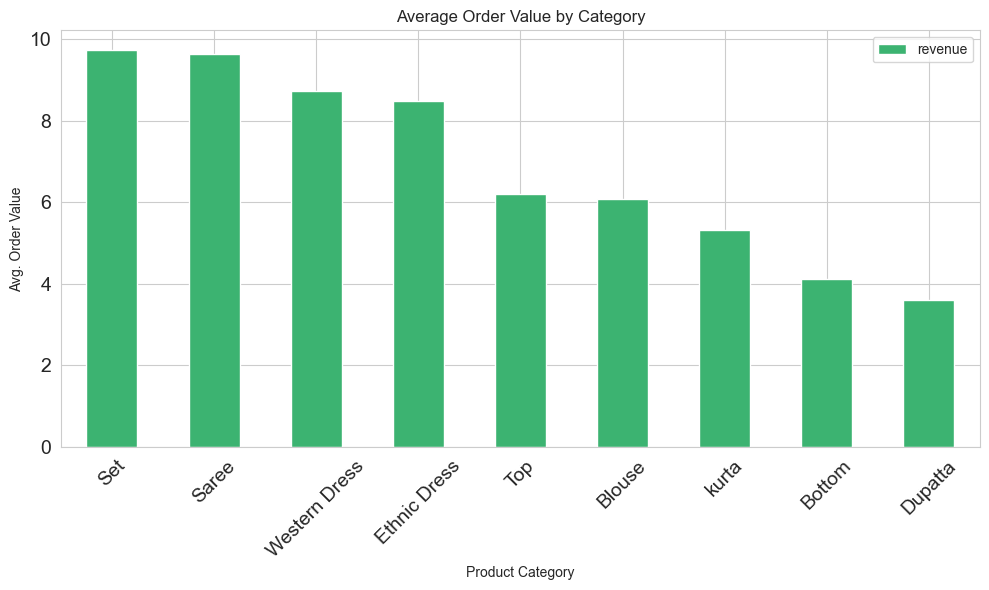

In [107]:
avg_order_value.plot(
    kind     ='bar', 
    color    ='mediumseagreen',
    title    ='Average Order Value by Category',
    xlabel   ='Product Category',
    ylabel   ='Avg. Order Value',
    figsize  =(10, 6),
    fontsize =14
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mhm, an interesting pattern emerges, let's overlay this with our previous plot:

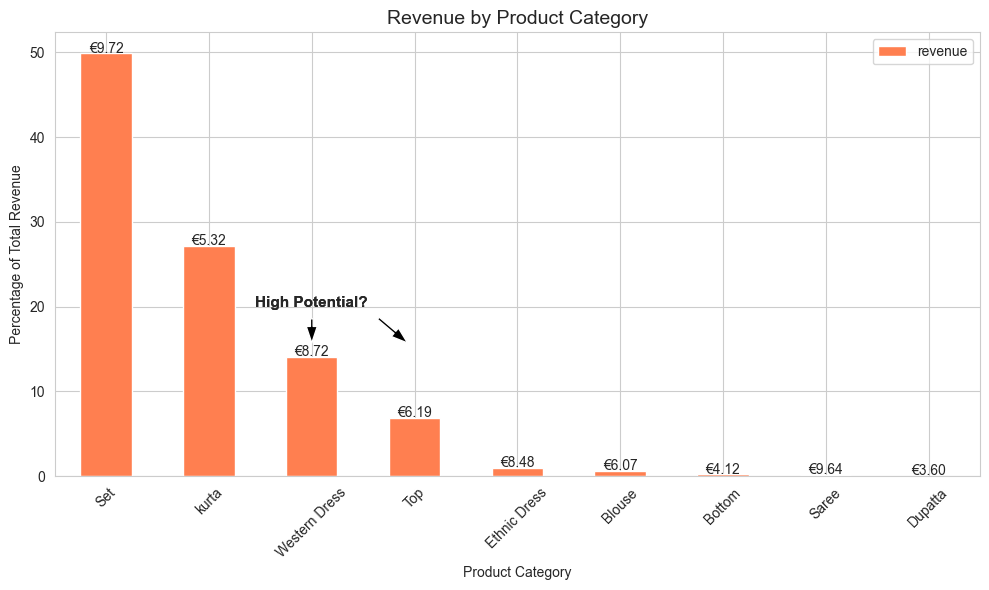

In [108]:
fig, ax = plt.subplots(figsize=(10,6))

bar_colors = ['green' if cat in ['Western Dress', 'Set'] else 'coral' for cat in category_revenue.index]

category_revenue.plot(kind='bar', color='coral', ax=ax)

for i, category in enumerate(category_revenue.index):
    avg_cost = df[df['category'] == category]['revenue'].mean()
    ax.text(i, category_revenue.values[i] +.1, f'€{avg_cost:.2f}', ha='center', fontsize=10)

ax.annotate(
    'High Potential?',
    xy=(2, 15),
    xytext=(2, 15 + 5),
    arrowprops=dict(facecolor='black', shrink=0.15, width=2, headwidth=8),
    ha='center',
    fontsize=11,
    fontweight='bold'
)
ax.annotate(
    'High Potential?',
    xy=(3, 15),
    xytext=(2, 20),
    arrowprops=dict(facecolor='black', shrink=0.15, width=2, headwidth=8),
    ha='center',
    fontsize=11,
    fontweight='bold'
)


plt.title('Revenue by Product Category', fontsize=14)
plt.xlabel('Product Category')
plt.ylabel('Percentage of Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analysis: Product Portfolio Matrix

We can think of each product category as a portfolio element. High revenue = popularity. High AOV = profitability per sale. Plotting these gives us a clear 2x2 matrix for strategy.


|                             | **Low AOV** (below median)                           | **High AOV** (above median)                         |
|-----------------------------|------------------------------------------------------|-----------------------------------------------------|
| **Low Revenue** (left side) | ❌ **Underperformers**<br>Consider retiring or repositioning | 🎯 **Niche Upside**<br>Test with promos or better visibility |
| **High Revenue** (right side) | 📦 **Volume Drivers**<br>Focus on logistics, bundling, efficiency | ⭐ **Premium Performers**<br>Upsell, promote, ...

In [109]:
import matplotlib.pyplot as plt

# Calculate total revenue and AOV per category
category_metrics = df.groupby('category').agg(
    total_revenue   = ('revenue', 'sum'),
    avg_order_value = ('revenue', 'mean')
).reset_index()
category_metrics

,category,total_revenue,avg_order_value
0,Blouse,5204.38,6.065711
1,Bottom,1685.54,4.121125
2,Dupatta,10.80,3.600000
3,Ethnic Dress,8990.13,8.481255
4,Saree,1484.04,9.636623
5,Set,446968.24,9.720927
6,Top,61811.64,6.188590
7,Western Dress,126292.35,8.723655
8,kurta,243591.56,5.319058


**You try it**

Try to scatter plot the total revenue v.s. median order value. The command you'll use is `.plot.scatter(x=...,y=...)`.

Here's a fancy version, which assumes you have already calculated the correct avg order value :-)

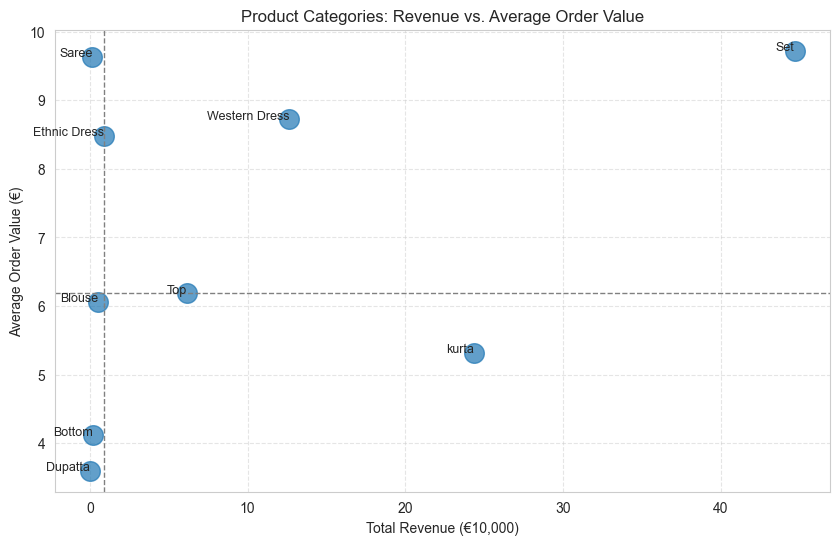

In [110]:
# Create scatter plot
category_metrics['revenue_10k'] = category_metrics['total_revenue'] / 10000

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    category_metrics['revenue_10k'],
    category_metrics['avg_order_value'],
    s=200, 
    alpha=0.7,
)

# Annotate each point with the category name
for _, row in category_metrics.iterrows():
    ax.text(row['revenue_10k'], row['avg_order_value'], row['category'], fontsize=9, ha='right')

# Add reference lines for median revenue and median AOV
median_revenue = category_metrics['revenue_10k'].median()
median_aov     = category_metrics['avg_order_value'].median()

ax.axhline(median_aov,     color='gray', linestyle='--', linewidth=1)
ax.axvline(median_revenue, color='gray', linestyle='--', linewidth=1)

# Titles and labels
ax.set(
    title='Product Categories: Revenue vs. Average Order Value',
    xlabel='Total Revenue (€10,000)',
    ylabel='Average Order Value (€)'
)
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

Of course, we can also do this at the SKU level (which probably makes more sense for Amazon).

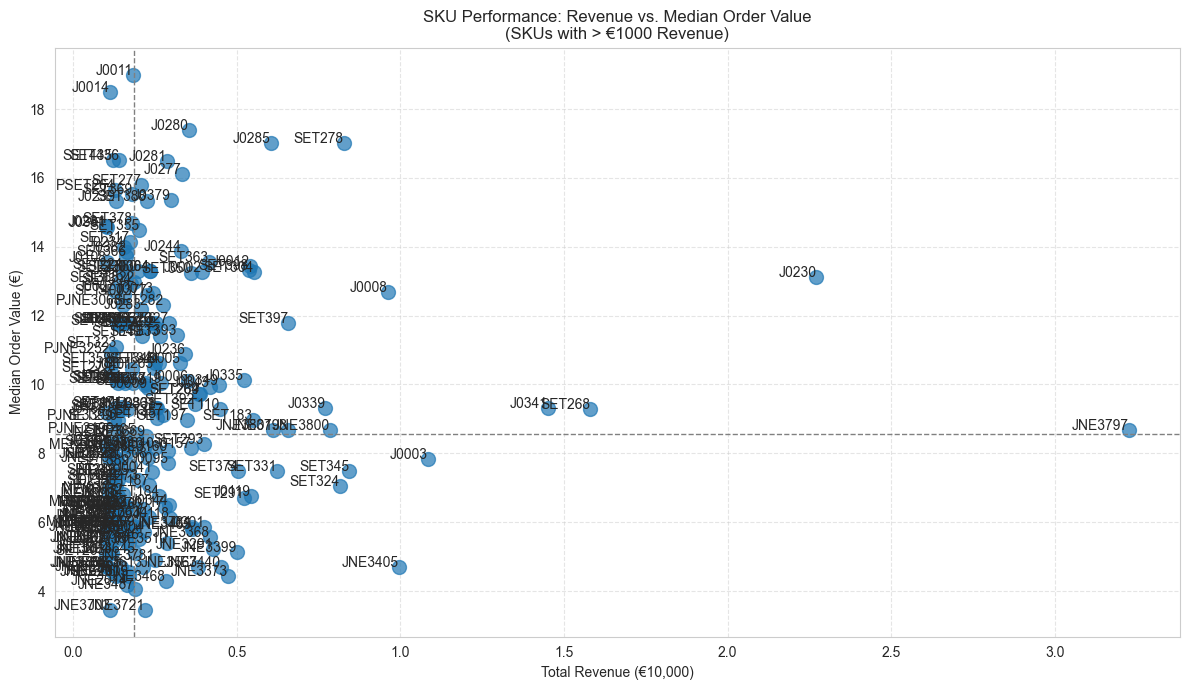

In [114]:
import matplotlib.pyplot as plt

# Calculate total revenue and AOV per SKU
sku_metrics = df.groupby('base-SKU').agg(
    total_revenue        = ('revenue', 'sum'),
    median_order_value   = ('revenue', 'median')
).reset_index()

sku_metrics = sku_metrics[sku_metrics['total_revenue'] > 1000]

# Scale revenue for plot readability
sku_metrics['revenue_10k'] = sku_metrics['total_revenue'] / 10000

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 7))
scatter = ax.scatter(
    sku_metrics['revenue_10k'],
    sku_metrics['median_order_value'],
    s=100, alpha=0.7
)

# Annotate each point with the SKU (shortened if necessary)
for _, row in sku_metrics.iterrows():
    label = str(row['base-SKU'])[:15]  # truncate if SKUs are long
    ax.text(row['revenue_10k'], row['median_order_value'], label, fontsize=10, ha='right')

# Add reference lines for medians
median_revenue = sku_metrics['revenue_10k'].median()
median_aov     = sku_metrics['median_order_value'].median()

ax.axhline(median_aov,     color='gray', linestyle='--', linewidth=1)
ax.axvline(median_revenue, color='gray', linestyle='--', linewidth=1)

# Titles and labels
ax.set(
    title='SKU Performance: Revenue vs. Median Order Value\n(SKUs with > €1000 Revenue)',
    xlabel='Total Revenue (€10,000)',
    ylabel='Median Order Value (€)'
)

ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Credits: original data source from [here](https://data.world/anilsharma87).